VectorAdam for Rotation Equivariant Geometry Optimization
======================================

This is an example on how to use VectorAdam for Laplacian smoothing in 2D.

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import math
from util import *
from vectoradam import *
import matplotlib.pyplot as plt
from skimage import measure
from skimage.draw import disk
import imageio
import scipy
from nanomesh import Image as nmImg
from nanomesh import Mesher2D
import trimesh
import igl
import cv2
from svgpathtools import svg2paths

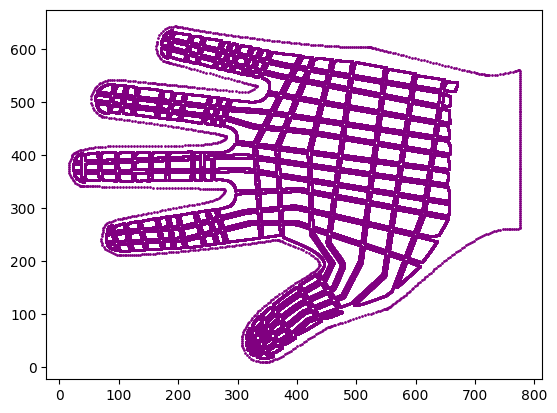

In [79]:
def samplePaths(file, NUM_SAMPLES=1000):
    # Load paths from SVG file
    paths, attributes = svg2paths(file)
    points = []
    for path in paths:
        for i in range(NUM_SAMPLES):
            points.append([path.point(i/(NUM_SAMPLES-1)).imag, path.point(i/(NUM_SAMPLES-1)).real])
    return np.array(points)
        
outerCut = samplePaths('outerOnly.svg')
topTraces = samplePaths('top_trace.svg')
botttomTraces = samplePaths('bottom_trace.svg')
edgeCuts = samplePaths('edgeCuts.svg')
coverlayMask = samplePaths('solderMask.svg')



# Print the flipped vertices
# plt.scatter(*zip(*outerCut), color='blue',s=1)
# plt.scatter(*zip(*topTraces), color='red',s=1)
# plt.scatter(*zip(*botttomTraces), color='green',s=1)
plt.scatter(*zip(*edgeCuts), color='purple',s=1)
# plt.scatter(*zip(*coverlayMask), color='orange',s=1)

C:\Users\devin\AppData\Local\Temp\ipykernel_14520\3110076907.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread('hand.png')


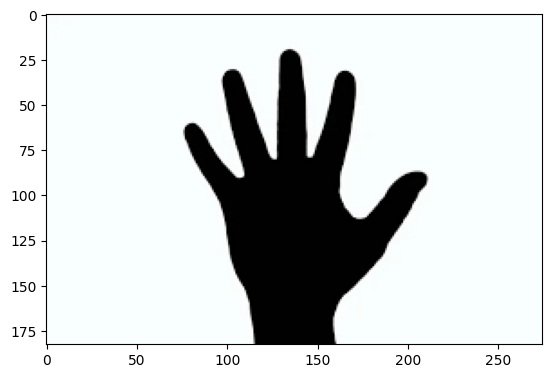

C:\Users\devin\AppData\Local\Temp\ipykernel_14520\3110076907.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread('hand6.jpg')


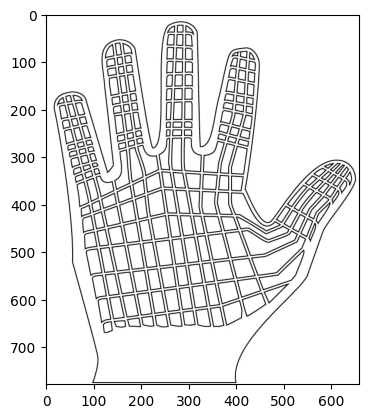

In [11]:
img1 = imageio.imread('hand.png')
plt.imshow(img1)
plt.show()
img2 = imageio.imread('hand6.jpg')
img2 = np.fliplr(img2)
plt.imshow(img2)
plt.show()

<Axes: xlabel='x', ylabel='y'>

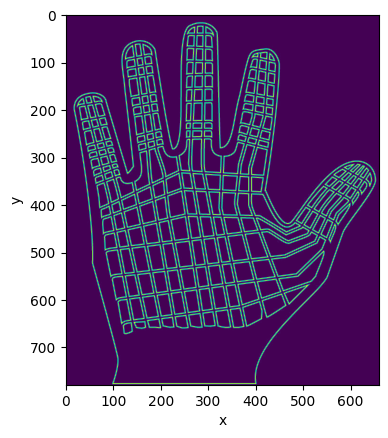

In [12]:
binary_image = img2.sum(-1) / img2.sum(-1).max()
meshImg = nmImg(binary_image)
meshImg.show()




<class 'nanomesh.mesh._line.LineMesh'>
<class 'nanomesh.mesh_container.MeshContainer'>


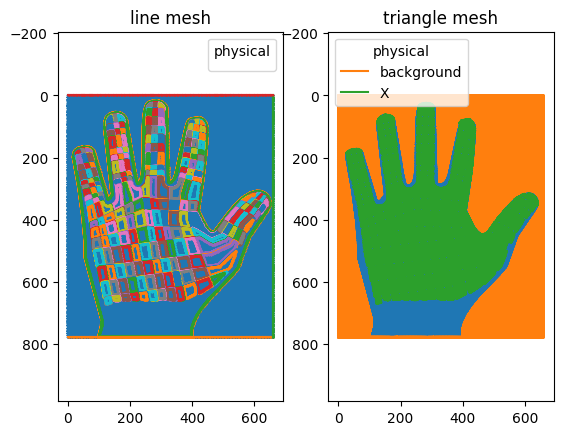

In [13]:
mesher = Mesher2D(meshImg)
mesher.generate_contour()
print(type(mesher.contour))
mesh = mesher.triangulate()
mesh.plot()
print(type(mesh))

{'segment_markers': array([  1,   1,   1, ..., 461, 462, 463])}
1


<Axes: title={'center': 'triangle mesh'}>

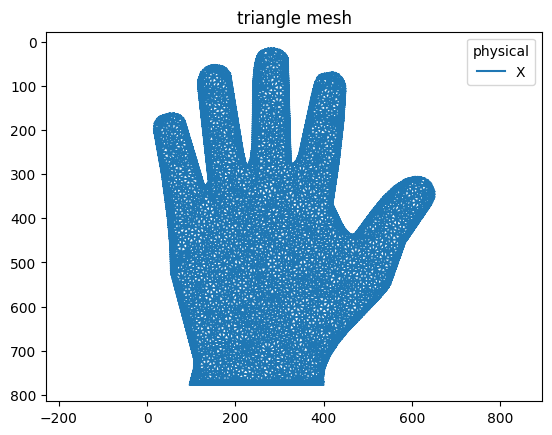

In [14]:
mesher = Mesher2D(meshImg)
mesher.generate_contour()
contour = mesher.contour
print(contour.cell_data)

values, counts = np.unique(contour.cell_data['segment_markers'], return_counts=True)

# Get the most frequent element
most_frequent = values[np.argmax(counts)]
print(most_frequent)
for el in values:
    if el!=most_frequent:
        contour.remove_cells(label=el)
mesh = contour.triangulate()
mesh.plot()

In [5]:
print(mesh.get('triangle').cells.shape)

(5909, 3)


('triangle',)


<Axes: title={'center': 'triangle mesh'}>

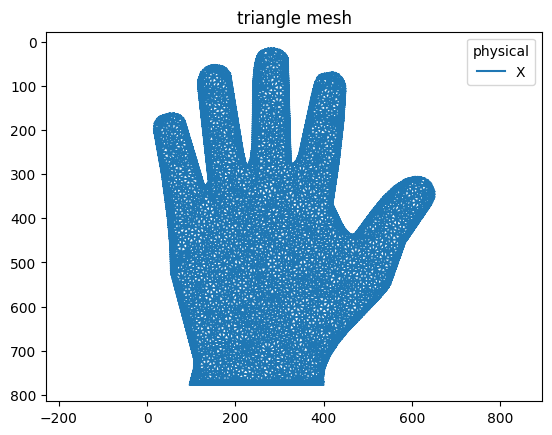

In [16]:
print(mesh.cell_types)
triangles = mesh.get('triangle')
# triangles.remove_cells(label=1)
triangles.plot()
# print(triangles.dimensions)
# x=triangles.get_cell_data('physical')
# print(triangles.points.shape)
# print(type(triangles.points))
# print(type(x))
# print(x.shape)

In [85]:
print(dir(triangles))
print(triangles.cells.shape)
print(triangles.cell_data['physical'].shape)

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_docstring_components', '_regenerate_cell_indices', '_registry', 'cell_centers', 'cell_data', 'cell_type', 'cells', 'crop', 'default_key', 'dimensions', 'field_to_number', 'fields', 'from_meshio', 'from_open3d', 'from_scipy', 'from_triangle_dict', 'from_trimesh', 'get_cell_data', 'labels', 'number_to_field', 'optimize', 'plot', 'plot_itk', 'plot_mpl', 'plot_pyvista', 'points', 'prune_z_0', 'read', 'region_markers', 'remove_cells', 'remove_loose_points', 'reverse_cell_order', 'tetrahedralize', 'to_meshio', 'to_open3d', 'to_polydata', 'to_pyvista_unstructured_grid', 'to_trimesh', 'write', 'zero_labels']
(46854, 3)

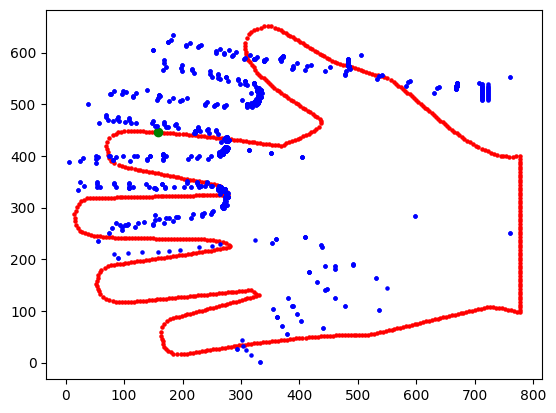

In [ ]:
# For each cell data X and physical
#   generate edges from cells
#   identify boundary edges
#   boundary edges that are shared by cells in X and cells in physical are inner edges
#   Remove these shared edges from physical, what is left should be the points on the boundary

import numpy as np
from collections import Counter, defaultdict



def find_outer_boundary_points(points, cells):
    # Step 1: Generate edges from cells
    edges = []
    
    for cell in cells:
        # Get the triangle vertices
        i, j, k = cell
        # Add the edges, sorted to ensure consistency (min, max)
        edges.append(tuple(sorted([i, j])))
        edges.append(tuple(sorted([j, k])))
        edges.append(tuple(sorted([k, i])))

    # Step 2: Count occurrences of each edge
    edge_counts = Counter(edges)

    # Step 3: Identify boundary edges (edges that appear exactly once)
    boundary_edges = [edge for edge, count in edge_counts.items() if count == 1]

    # Step 4: Extract the points from the boundary edges
    boundary_points = set()
    for edge in boundary_edges:
        boundary_points.update(edge)
    
    return boundary_points, boundary_edges

# xCells = triangles.cells[triangles.cell_data['physical']==2]
# physCells = triangles.cells[triangles.cell_data['physical']==0]

# xBounds, _ = find_outer_boundary_points(triangles.points, xCells)
boundary_vertices, boundary_edges = find_outer_boundary_points(triangles.points, triangles.cells)
adjacency = defaultdict(list)
def appendAdjacent(edge):
    adjacency[edge[0]].append(edge[1])
    adjacency[edge[1]].append(edge[0])
for edge in boundary_edges:
    appendAdjacent(edge)
# Step 2: Start traversal
ordered_points = []
visited = set()

# Pick an arbitrary starting point
start = next(iter(boundary_vertices))
current = start
previous = None

while current not in visited:
    ordered_points.append(current)
    visited.add(current)
    # Find the next point that isn't the previous one
    next_points = adjacency[current]
    next_point = next(pt for pt in next_points if pt != previous)
    previous, current = current, next_point
handEdge = triangles.points[ordered_points]
plt.figure()
plt.scatter(*zip(*handEdge), color='red', s=5)
plt.scatter(handEdge[500,0],handEdge[500,1], color='green')
plt.show()

1
699


C:\Users\devin\AppData\Local\Temp\ipykernel_21392\2982217211.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  binary_image = imageio.imread(file)


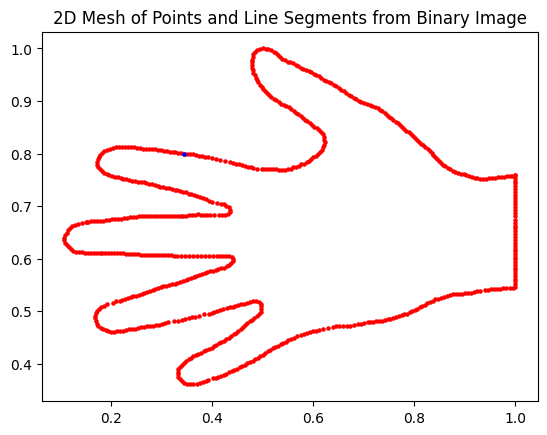

In [10]:
import numpy as np
import imageio
from skimage import measure

def image_to_mesh(sourceEdges, file, num_points=10000):

    binary_image = imageio.imread(file)
    if '6' in file:
        binary_image = np.fliplr(binary_image)
    binary_image = binary_image.sum(-1) / binary_image.sum(-1).max()
    # Find contours in the binary image
    contours = measure.find_contours(binary_image, level=0.5)

    # Prepare points and line segments
    points = []
    line_segments = []

    contours = measure.find_contours(binary_image, level=0.5)
    
    points = []
    line_segments = []
    print(len(contours))

    for contour in contours:
        contour = np.vstack([contour, contour[0]])

        #sourceEdge distance
        sourceDistances = np.sqrt(np.sum(np.diff(sourceEdges, axis=0)**2, axis=1))
        cumulative_source = np.insert(np.cumsum(sourceDistances), 0, 0)
        sourceDistanceTotal = cumulative_source[-1]

        # Calculate cumulative distance along the contour
        distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
        cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
        target_total = cumulative_distances[-1]
        
        # Interpolate to get the specified number of points
        # desired_distances = np.linspace(0, cumulative_distances[-1], num_points)
        desired_distances = []
        for n in range(0, num_points):
            desired_distances.append((cumulative_source[n]/sourceDistanceTotal)*target_total)
        interpolated_points = np.array([
            np.interp(desired_distances, cumulative_distances, contour[:, dim])
            for dim in range(contour.shape[1])
        ]).T
        
        # Add interpolated points to the main list
        points.extend(interpolated_points)

        # adjacency = defaultdict(list)
        # def appendAdjacent(edge):
        #     adjacency[edge[0]].append(edge[1])
        #     adjacency[edge[1]].append(edge[0])
        # for edge in physEdges:
        #     appendAdjacent(edge)
        # boundary_vertices = np.array(list(physBounds-xBounds))
        # # Step 2: Start traversal
        # ordered_points = []
        # visited = set()

        # # Pick an arbitrary starting point
        # start = next(iter(boundary_vertices))
        # current = start
        # previous = None

        # while current not in visited:
        #     ordered_points.append(current)
        #     visited.add(current)
        #     # Find the next point that isn't the previous one
        #     next_points = adjacency[current]
        #     next_point = next(pt for pt in next_points if pt != previous)
        #     previous, current = current, next_point
    
        
        # Create line segments between consecutive points
        for i in range(len(points) - 1):
            line_segments.append((i, i + 1))
        
        # Connect the last point to the first to close the loop
        line_segments.append((i+1, 0))
    
    s = np.array(points).max(0)
    
    points = points / s
    
    return points, line_segments,s

# Example usage:
# Assuming `handEdge` is the source contour and `hand.png` is the image file
v2, l2, s2 = image_to_mesh(handEdge,'hand.png', num_points=len(boundary_vertices))
v2=v2[::-1]

print(len(v2))



fig = plt.figure()
# for segment in l1:
#     x_values = [segment[0][1], segment[1][1]]
#     y_values = [segment[0][0], segment[1][0]]
    # plt.plot(x_values, y_values, 'b')
plt.scatter(*zip(*v2), color='red', s=5)
plt.scatter(v2[500, 0], v2[500, 1], color='blue', s=5)

plt.title("2D Mesh of Points and Line Segments from Binary Image")
plt.show()

# fig = plt.figure()
# # for segment in l2:
# #     x_values = [segment[0][1], segment[1][1]]
# #     y_values = [segment[0][0], segment[1][0]]
#     # plt.plot(x_values, y_values, 'b')
# plt.scatter(*zip(*v2), color='red', s=5)
# plt.title("2D Mesh of Points and Line Segments from Binary Image")
# plt.show()
# # Points and line_segments contain the 2D mesh information


699 699
[0.00117236 0.00100799]


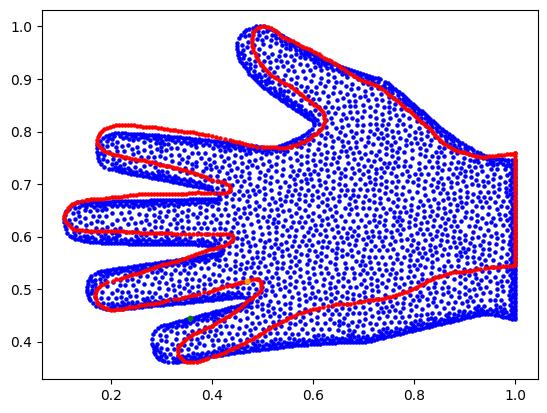

In [20]:
# rescale source to target:
print(len(v2), len(boundary_vertices))

v1=triangles.points
s = (v2.max(0) - v2.min(0)) / (v1.max(0) - v1.min(0))
v1_n = s * ( v1 - v1.min(0) ) + v2.min(0)
print(s)
plt.scatter(v1_n[:, 0], v1_n[:, 1], color='blue', s=5)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v1_n[ordered_points[200], 0], v1_n[ordered_points[200], 1], color='green', s=10)
plt.scatter(v2[200, 0], v2[200,1], color='orange', s=10)
plt.show()

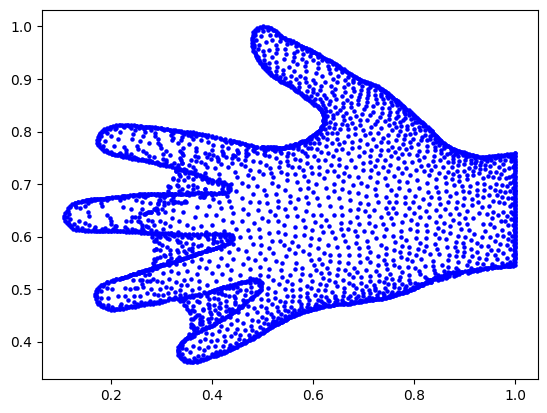

In [18]:
V = v1_n  # Vertices of the mesh
F = triangles.cells     # Faces (triangles) of the mesh
target_boundary_points = np.array(v2)

# Compute biharmonic weights using the boundary vertices as control points
weights = igl.harmonic(V, F, np.array(ordered_points), target_boundary_points, 2)
# deformed_vertices = np.dot(weights,V)
# 
# Step 6: Apply deformation# Map boundary vertices to target boundary positions
# deformed_vertices = V.copy()
# deformed_vertices[boundary_vertices] = target_boundary_points

# # Use biharmonic weights to smoothly deform the entire mesh
# new_vertices = weights @ deformed_vertices[boundary_vertices]

deformed_vertices = weights*V

plt.scatter(weights[:, 0], weights[:, 1], color='blue', s=5)


{'X': 2, 'background': 1}
{'physical': array([2., 2., 2., ..., 2., 2., 2.])}


<Axes: title={'center': 'triangle mesh'}>

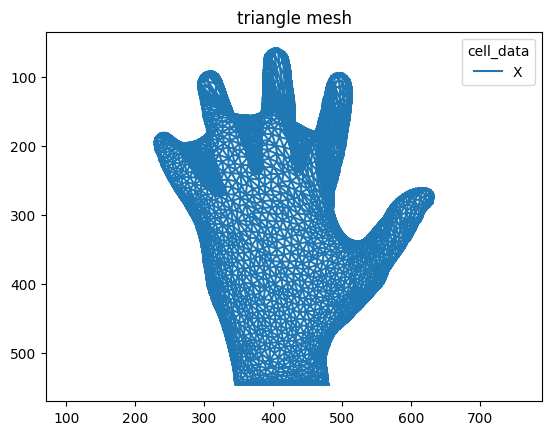

In [19]:
from nanomesh import TriangleMesh
print(triangles.field_to_number)
print(triangles.cell_data)
newMesh = TriangleMesh(weights*s2*3,F,fields=triangles.field_to_number, cell_data=triangles.cell_data['physical'])
newMesh.plot()

In [33]:
import numpy as np
from scipy.interpolate import griddata

def deform_image(source_image, source_vertices, deformed_vertices, faces):
    """
    Deforms a source grayscale image based on deformed vertices and mesh faces.
    
    Args:
        source_image (numpy.ndarray): The source grayscale image, shape (h, w).
        source_vertices (numpy.ndarray): Original vertex coordinates, shape (n, 2).
        deformed_vertices (numpy.ndarray): Deformed vertex coordinates, shape (n, 2).
        faces (numpy.ndarray): Mesh faces, shape (m, 3), indices of vertices forming triangles.
    
    Returns:
        numpy.ndarray: The deformed image, shape (h, w).
    """
    h, w = source_image.shape

    # Generate a grid of pixel coordinates
    grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=-1)

    simplex_indices = np.full(grid_points.shape[0], -1, dtype=int)
    barycentric_coords = np.zeros((grid_points.shape[0], 3))

    # Iterate over triangles
    for i, face in enumerate(faces):
        tri_vertices = source_vertices[face]
        mat = np.vstack([tri_vertices.T, [1, 1, 1]])

        # Skip degenerate triangles
        if np.linalg.det(mat) == 0:
            continue

        inv_mat = np.linalg.inv(mat)
        homog_grid = np.hstack([grid_points, np.ones((grid_points.shape[0], 1))])
        bary_coords = (inv_mat @ homog_grid.T).T

        # Find points inside the triangle
        valid = (bary_coords >= 0).all(axis=1)
        simplex_indices[valid] = i
        barycentric_coords[valid] = bary_coords[valid]

    # Map barycentric coordinates to deformed vertices
    valid = (simplex_indices >= 0) & (simplex_indices < len(faces))
    warped_points = (
        deformed_vertices[faces[simplex_indices[valid]]] * barycentric_coords[valid][:, :, None]
    ).sum(axis=1)

    # Map pixel values from the source image
    warped_image = np.zeros_like(source_image)
    interpolated_values = griddata(
        warped_points, 
        source_image.ravel()[valid],  # Flatten the valid pixel values
        (grid_x, grid_y), 
        method="linear", 
        fill_value=0
    )
    warped_image = interpolated_values

    return warped_image

warpedImg = deform_image(binary_image.T,triangles.points, weights*s2*3,F)

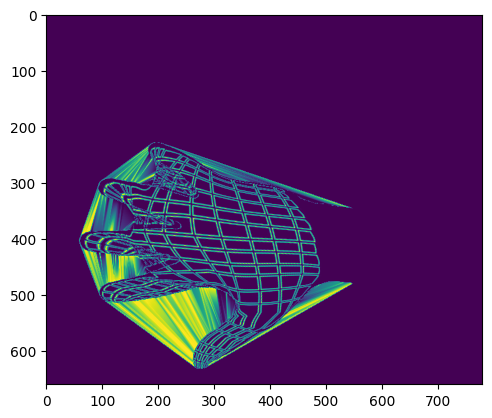

In [34]:
plt.imshow(warpedImg)

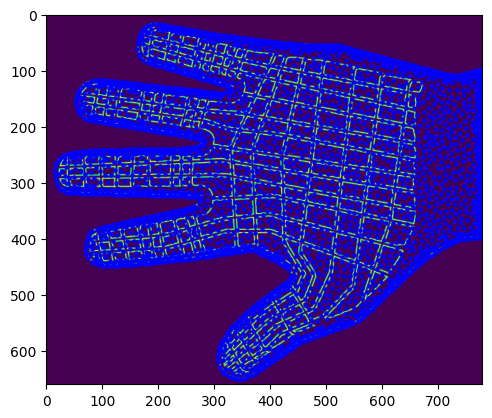

In [32]:
plt.figure()
plt.scatter(triangles.points[:, 0], triangles.points[:, 1], color='blue', s=5)
plt.imshow(binary_image.T)

In [24]:
print(binary_image.shape)

(779, 660)


(20, 2)
(1000, 2) (1000, 2)


/var/folders/7x/kskkjxy57jd61clrqy9ndysc0000gp/T/ipykernel_39842/2685789830.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  binary_image = imageio.imread(file)


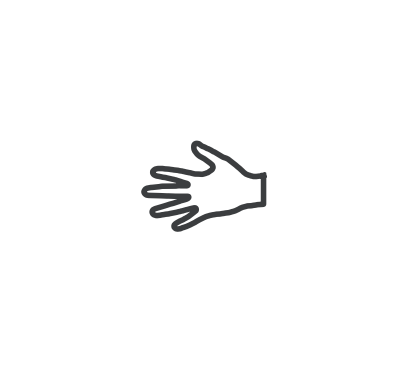

In [3]:
n = 12
vv1, ll2 = create_circle()
print(ll2.shape)
v1, l1 = image_to_mesh('hand.png')
v2, l2 = image_to_mesh('hand3.png')
v1 = np.array(v1)
l1 = np.array(l1)
v2 = np.array(v2)
l2 = np.array(l2)
print(v1.shape, l1.shape)
eps = 1
x_lim = [np.min(v1[:,0]) - eps, np.max(v1[:,0]) + eps]
y_lim = [np.min(v1[:,1]) - eps, np.max(v1[:,1]) + eps]

# keep track of meshes for later plotting
data= {}
data['original mesh'] = (v1, l1)

# plot the original mesh 
plot_mesh2d(v1,l1,x_lim=x_lim, y_lim=y_lim, showfig=True)

[0.10733404 0.36053928]
[1. 1.]


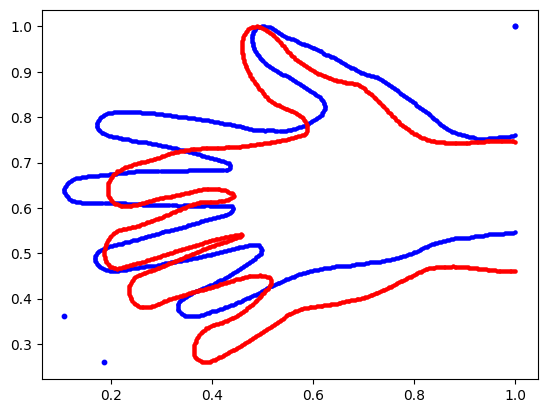

[0.91105461 1.15873116]


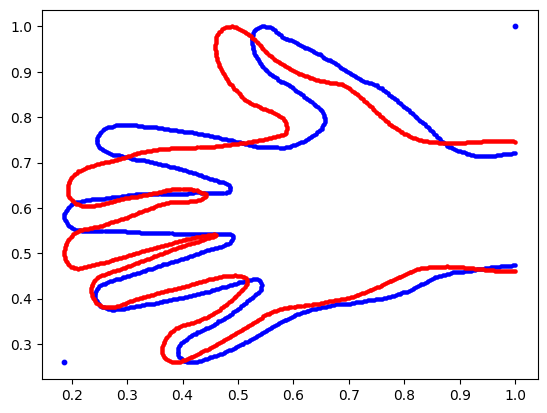

In [18]:
# naive rescale: 

print(v1.min(axis=0))
print(v1.max(axis=0))
plt.scatter(v1[:, 0], v1[:, 1], color='blue', s=5)
plt.scatter(v1.min(axis=0)[0], v1.min(axis=0)[1], color='blue', s=10)
plt.scatter(v1.max(axis=0)[0], v1.max(axis=0)[1], color='blue', s=10)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v2.min(axis=0)[0], v2.min(axis=0)[1], color='blue', s=10)
plt.scatter(v2.max(axis=0)[0], v2.max(axis=0)[1], color='blue', s=10)
plt.show()



# rescale source to target:
s = (v2.max(0) - v2.min(0)) / (v1.max(0) - v1.min(0))
v1_n = s * ( v1 - v1.min(0) ) + v2.min(0)
print(s)
plt.scatter(v1_n[:, 0], v1_n[:, 1], color='blue', s=5)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v2.min(axis=0)[0], v2.min(axis=0)[1], color='blue', s=10)
plt.scatter(v2.max(axis=0)[0], v2.max(axis=0)[1], color='blue', s=10)
plt.show()

In [29]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def biharmonic_weights(vertices, segments):
    """
    Compute biharmonic weights based on the mesh connectivity.
    """
    num_vertices = len(vertices)
    
    # Construct the Laplacian matrix based on the line segments
    L = sp.lil_matrix((num_vertices, num_vertices))
    for seg in segments:
        i, j = seg
        L[i, i] += 1
        L[j, j] += 1
        L[i, j] -= 1
        L[j, i] -= 1

    # Biharmonic weights: we solve for L.T * L to smooth out the deformation
    A = L.T @ L
    return A

def deform_shape(source_vertices, target_vertices, segments, alpha=0.1):
    """
    Deform the source shape to match the target shape using biharmonic weights.
    
    Parameters:
    - source_vertices: Nx2 array of (x, y) coordinates of the source shape.
    - target_vertices: Nx2 array of (x, y) coordinates of the target shape.
    - segments: List of pairs of indices defining the edges between vertices.
    - alpha: Regularization parameter for the biharmonic weights.
    
    Returns:
    - deformed_vertices: Nx2 array of the deformed vertices.
    """
    num_vertices = source_vertices.shape[0]

    # Compute biharmonic weights
    A = biharmonic_weights(source_vertices, segments)

    # Set up system of equations for x and y coordinates separately
    I = sp.identity(num_vertices)
    system_matrix = A + alpha * I  # Regularized biharmonic system

    # Deform along the x and y directions independently
    bx = alpha * target_vertices[:, 0]
    by = alpha * target_vertices[:, 1]
    
    # Solve for new positions
    deformed_x = spla.spsolve(system_matrix, bx)
    deformed_y = spla.spsolve(system_matrix, by)
    
    # Stack the deformed coordinates
    deformed_vertices = np.vstack((deformed_x, deformed_y)).T
    return deformed_vertices



# Perform deformation


In [32]:
control_points_indices = np.linspace(0, v1.shape[0] - 1, num=10, dtype=int)
deformed_vertices = deform_shape(v1_n, v2, l1)
print(deformed_vertices.shape)
print(deformed_vertices.max(), deformed_vertices.min())


(1000, 2)
0.9995788331545798 0.18680729707413884


[0.10733404 0.36053928]
[1. 1.]


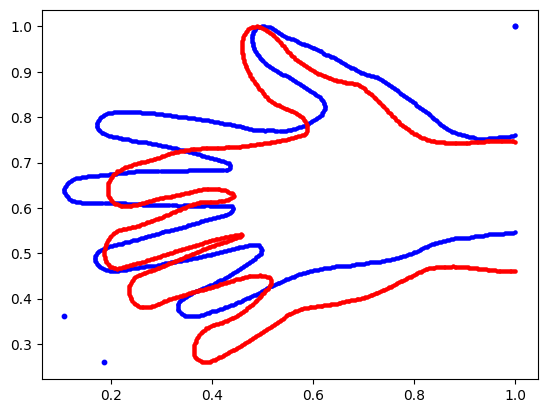

[0.91105461 1.15873116]


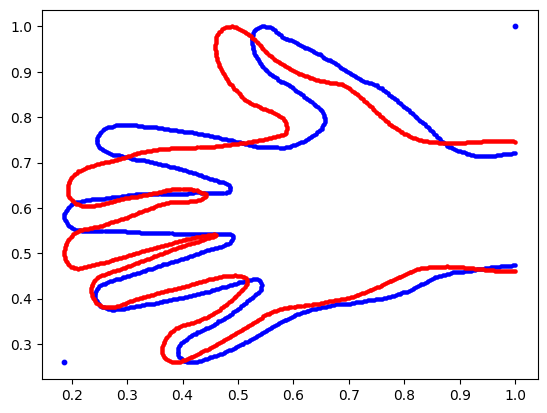

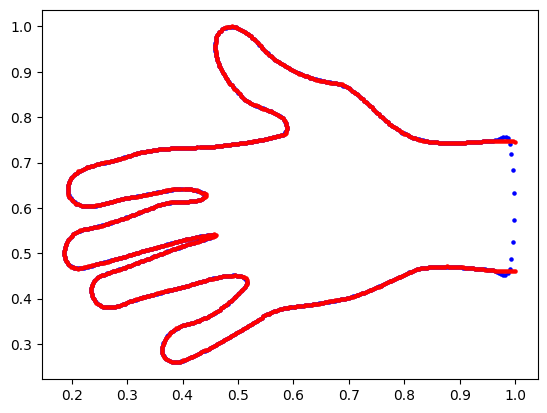

In [33]:

print(v1.min(axis=0))
print(v1.max(axis=0))
plt.scatter(v1[:, 0], v1[:, 1], color='blue', s=5)
plt.scatter(v1.min(axis=0)[0], v1.min(axis=0)[1], color='blue', s=10)
plt.scatter(v1.max(axis=0)[0], v1.max(axis=0)[1], color='blue', s=10)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v2.min(axis=0)[0], v2.min(axis=0)[1], color='blue', s=10)
plt.scatter(v2.max(axis=0)[0], v2.max(axis=0)[1], color='blue', s=10)
plt.show()



# rescale source to target:
s = (v2.max(0) - v2.min(0)) / (v1.max(0) - v1.min(0))
v1_n = s * ( v1 - v1.min(0) ) + v2.min(0)
print(s)
plt.scatter(v1_n[:, 0], v1_n[:, 1], color='blue', s=5)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.scatter(v2.min(axis=0)[0], v2.min(axis=0)[1], color='blue', s=10)
plt.scatter(v2.max(axis=0)[0], v2.max(axis=0)[1], color='blue', s=10)
plt.show()

plt.scatter(deformed_vertices[:, 0], deformed_vertices[:, 1], color='blue', s=5)
plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
plt.show()